In [20]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np

In [21]:
def readNames(file_name='data_set/sick'):
    dataset_labels = []
    with open(f"{file_name}.names", "r") as f:
        for line in f:
            colon_idx = line.find(":")
            name = line[:colon_idx]
            dataset_labels.append(name)
    return dataset_labels

def clean_data(data):#deleting columns which informing us if feature is measured or not
    del data['TSH measured']
    del data['T3 measured']
    del data['TT4 measured']
    del data['T4U measured']
    del data['FTI measured']
    del data['TBG measured']
    del data['TBG']
    
def corelation(data,method=False):     #pearson, kendall, spearman 
    corr_algo = "pearson" if not method else method
    return data.corr(method=corr_algo)

def readDataset(dataset_name = 'data_set/sick.data'):
    readed_names = readNames()
    readed_data = pd.read_csv(dataset_name,
                          names=readed_names,
                          true_values=['t'],
                          false_values=['f'],
                          na_values=["?"])
    return readed_data

def corr(readed_data):
    corelation_value = corelation(readed_data)
    s = corelation(readed_data).abs().unstack().sort_values(kind='quicksort')
    s = s.drop_duplicates(keep='first')
    for i in s:
        print(s)
        
def delete_problematic_atributes(readed_data):
    del readed_data['FTI']
    del readed_data['referral source']
    
def data_standarization(readed_data):
    readed_data['whatever'].replace(to_replace=r'.*negative.*', value='nagative', regex=True,inplace=True)
    readed_data['whatever'].replace(to_replace=r'sick.*', value='sick', regex=True,inplace=True)
    readed_data.replace(to_replace=False,value=0,inplace=True)
    readed_data.replace(to_replace=True,value=1,inplace=True)
    readed_data.replace(to_replace='F',value=0,inplace=True) # female = 0, male =1
    readed_data.replace(to_replace='M',value=1,inplace=True) # female = 0, male =1
    readed_data.fillna(0,inplace=True)
    readed_data.replace(to_replace="nagative",value=0,inplace=True)
    readed_data.replace(to_replace="sick",value=1,inplace=True)
    
    return readed_data

def split_atributes_from_results(readed_data):
    y_set = readed_data['whatever'][:]
    x_set = readed_data[:]
    del x_set['whatever']
    
    return x_set, y_set





In [22]:

readed_data = readDataset()
clean_data(readed_data)
#corr(readed_data) // don't need to use more than once
'''
po analizie korelacji stwierdzamy zże TT4 i FTI są sbyt skorelowane i wyrzycamy FTI bo ma mnej wartości niebędąych
nullami
potem jeszcze wywalamy referral source (bo mi sie nie chiało tego standaryzowac)
'''
delete_problematic_atributes(readed_data)
data_standarization(readed_data)

x_set , y_set = split_atributes_from_results(readed_data)

# ranking cech
select_feature = SelectKBest(chi2, k='all').fit(x_set, y_set)
selected_features_df = pd.DataFrame({'Feature':list(x_set.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

Feature      Scores
0                         age  531.907507
18                        TT4  105.482713
17                         T3   57.466796
5                        sick   20.179940
14              hypopituitary   15.374269
9           query hypothyroid   10.796240
2                on thyroxine   10.586381
1                         sex    4.250914
10         query hyperthyroid    3.122262
13                      tumor    2.733642
6                    pregnant    2.666793
7             thyroid surgery    2.536706
4   on antithyroid medication    2.211487
16                        TSH    1.796371
19                        T4U    1.386628
8              I131 treatment    1.355331
3          query on thyroxine    1.057125
15                      psych    0.650864
12                     goitre    0.156209
11                    lithium    0.026190

In [23]:
#prepare test split
X=x_set
y=y_set

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import copy
scores = []


#scoress = np.zeros()

def train_evaluate(X, y, hidden_layer_width=50, momentum=True):
    for i in range(1, 8):        
        z = SelectKBest(chi2, k=i).fit(X, y)       
        X_local = z.transform(X)
        y_local = copy.deepcopy(y)
        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        
        momentum_value = 0.9 if momentum else 0.0
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_width,),
                            max_iter=1000,
                            alpha=0.0001,
                            momentum=momentum_value,
                            nesterovs_momentum=momentum,
                            solver='sgd',
                            verbose=False,
                            tol=0.0001,
                            random_state=1234)

        for train_index, test_index in kf.split(X_local):
            x_train, x_test = X_local[train_index], X_local[test_index]
            y_train, y_test = y_local[train_index], y_local[test_index]

            mlp.fit(x_train, y_train)
            prediction = mlp.predict(x_test)
            conf_mat = confusion_matrix(y_test, prediction)
            s = mlp.score(x_test, y_test)
            print(f"Score for {hidden_layer_width}, momentum: {momentum}, count folds: {i}, Score: {s}")
            
            scores.append({
                    "scores": s,
                    "layer_width": hidden_layer_width,
                    "momentum": momentum,
                    "feature_number": i,
                    "confusion_matrix": conf_mat
                })

In [25]:
layer_widths = [10,50,100]
momentum = [False, True]

for width in layer_widths:
    print("Hidden layer width: " + str(width))
    for m in momentum:
        print("Momentum: " + str(m))
        train_evaluate(X, y, width, m)
        
scores
np.save('results', scores)

Hidden layer width: 10
Momentum: False
Score for 10, momentum: False, count folds: 1, Score: 0.9178571428571428
Score for 10, momentum: False, count folds: 1, Score: 0.9410714285714286
Score for 10, momentum: False, count folds: 1, Score: 0.9446428571428571
Score for 10, momentum: False, count folds: 1, Score: 0.9392857142857143
Score for 10, momentum: False, count folds: 1, Score: 0.95
Score for 10, momentum: False, count folds: 2, Score: 0.9178571428571428
Score for 10, momentum: False, count folds: 2, Score: 0.9410714285714286
Score for 10, momentum: False, count folds: 2, Score: 0.9446428571428571
Score for 10, momentum: False, count folds: 2, Score: 0.9392857142857143
Score for 10, momentum: False, count folds: 2, Score: 0.9517857142857142
Score for 10, momentum: False, count folds: 3, Score: 0.9178571428571428
Score for 10, momentum: False, count folds: 3, Score: 0.9410714285714286
Score for 10, momentum: False, count folds: 3, Score: 0.9446428571428571
Score for 10, momentum: Fa

Score for 50, momentum: True, count folds: 2, Score: 0.9392857142857143
Score for 50, momentum: True, count folds: 2, Score: 0.9482142857142857
Score for 50, momentum: True, count folds: 3, Score: 0.9178571428571428
Score for 50, momentum: True, count folds: 3, Score: 0.9410714285714286
Score for 50, momentum: True, count folds: 3, Score: 0.9446428571428571
Score for 50, momentum: True, count folds: 3, Score: 0.9392857142857143
Score for 50, momentum: True, count folds: 3, Score: 0.9517857142857142
Score for 50, momentum: True, count folds: 4, Score: 0.9178571428571428
Score for 50, momentum: True, count folds: 4, Score: 0.9410714285714286
Score for 50, momentum: True, count folds: 4, Score: 0.9446428571428571
Score for 50, momentum: True, count folds: 4, Score: 0.9392857142857143
Score for 50, momentum: True, count folds: 4, Score: 0.9553571428571429
Score for 50, momentum: True, count folds: 5, Score: 0.9160714285714285
Score for 50, momentum: True, count folds: 5, Score: 0.935714285

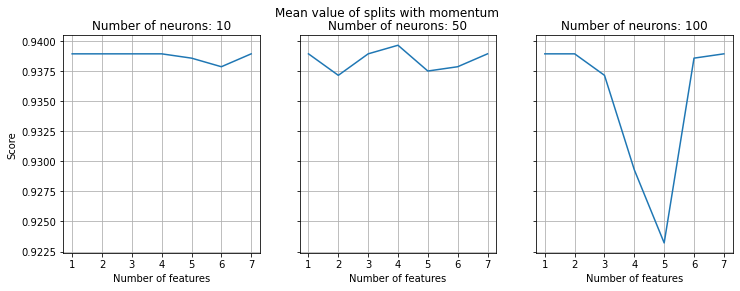

In [26]:
#wykresy
import pprint
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.axis import Axis
from matplotlib.figure import Figure

c_data = {}
plot_with_momentum = True

d = np.load("results.npy", allow_pickle=True)

for i in d:
    if i["layer_width"] in c_data:
        if i["feature_number"] in c_data[i["layer_width"]]:
            pass
        else:
            c_data[i["layer_width"]].update({i["feature_number"]: np.mean([j["scores"] for j in d if j["layer_width"] == i["layer_width"] and j["feature_number"] == i["feature_number"] and j["momentum"] is plot_with_momentum])})
    else:
        c_data.update({i["layer_width"]: {}})

pp = pprint.PrettyPrinter(indent=4)

fig: Figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# pp.pprint(c_data)
fig.suptitle("Mean value of splits with momentum")
for idx, data in enumerate(c_data.keys()):
    names = list(c_data[data].keys())
    values = list(c_data[data].values())
    ax[idx].set_title(f"Number of neurons: {data}")
    ax[idx].plot(names, values)
    ax[idx].set_xticks(range(1,8))
    ax[idx].grid(axis='both')
    ax[idx].set_xlabel("Number of features")
    ax[0].set_ylabel("Score")

plt.savefig("mean_with_momentum.png")    

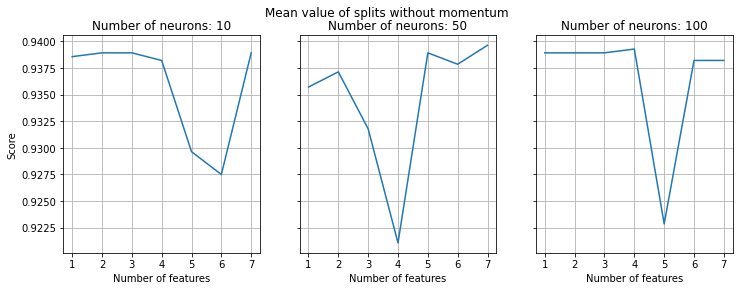

In [27]:
#wykresy
import pprint
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.axis import Axis
from matplotlib.figure import Figure

c_data = {}
plot_with_momentum = False

d = np.load("results.npy", allow_pickle=True)

for i in d:
    if i["layer_width"] in c_data:
        if i["feature_number"] in c_data[i["layer_width"]]:
            pass
        else:
            c_data[i["layer_width"]].update({i["feature_number"]: np.mean([j["scores"] for j in d if j["layer_width"] == i["layer_width"] and j["feature_number"] == i["feature_number"] and j["momentum"] is plot_with_momentum])})
    else:
        c_data.update({i["layer_width"]: {}})

pp = pprint.PrettyPrinter(indent=4)

fig: Figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# pp.pprint(c_data)
fig.suptitle("Mean value of splits without momentum")
for idx, data in enumerate(c_data.keys()):
    names = list(c_data[data].keys())
    values = list(c_data[data].values())
    ax[idx].set_title(f"Number of neurons: {data}")
    ax[idx].plot(names, values)
    ax[idx].grid(axis='both')
    ax[idx].set_xticks(range(1,8))
    ax[idx].set_xlabel("Number of features")
    ax[0].set_ylabel("Score")
    

plt.savefig("mean_without_momentum.png")  

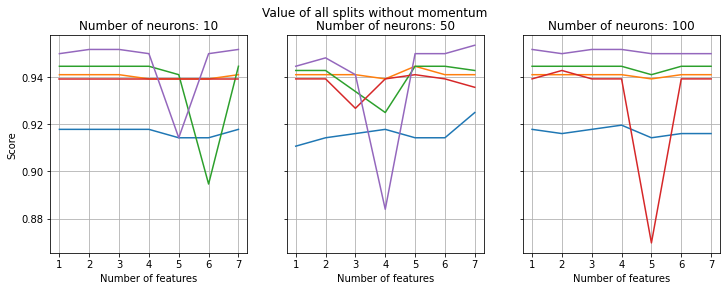

In [28]:
c_data = {}
plot_with_momentum = False

d = np.load("results.npy", allow_pickle=True)

for i in d:
    if i["layer_width"] in c_data:
        if i["feature_number"] in c_data[i["layer_width"]]:
            pass
        else:
            c_data[i["layer_width"]].update({i["feature_number"]: [j["scores"] for j in d if j["layer_width"] == i["layer_width"] and j["feature_number"] == i["feature_number"] and j["momentum"] is plot_with_momentum]})
    else:
        c_data.update({i["layer_width"]: {}})

pp = pprint.PrettyPrinter(indent=4)

fig: Figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# pp.pprint(c_data)
fig.suptitle("Value of all splits without momentum")
for idx, data in enumerate(c_data.keys()):
    names = list(c_data[data].keys())
    values = list(c_data[data].values())
    ax[idx].set_title(f"Number of neurons: {data}")
    ax[idx].plot(names, values)
    ax[idx].grid(axis='both')
    ax[idx].set_xlabel("Number of features")
    ax[idx].set_xticks(range(1,8))
    ax[0].set_ylabel("Score")
    
plt.savefig("all_split_without_momentum.png")  

{   10: {   1: [   0.9178571428571428,
                   0.9410714285714286,
                   0.9446428571428571,
                   0.9392857142857143,
                   0.9517857142857142],
            2: [   0.9178571428571428,
                   0.9410714285714286,
                   0.9446428571428571,
                   0.9392857142857143,
                   0.9517857142857142],
            3: [   0.9178571428571428,
                   0.9410714285714286,
                   0.9446428571428571,
                   0.9392857142857143,
                   0.9517857142857142],
            4: [   0.9178571428571428,
                   0.9410714285714286,
                   0.9446428571428571,
                   0.9392857142857143,
                   0.9517857142857142],
            5: [   0.9178571428571428,
                   0.9392857142857143,
                   0.9446428571428571,
                   0.9392857142857143,
                   0.9517857142857142],
            6: [   0

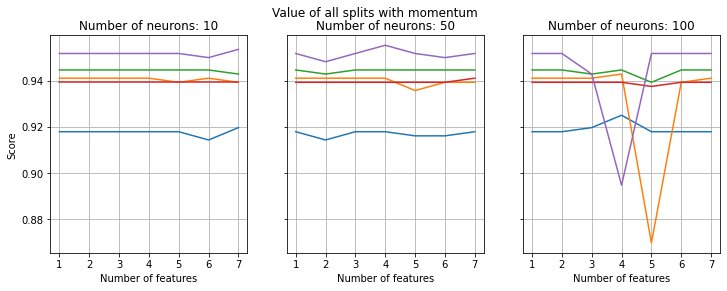

In [29]:
c_data = {}
plot_with_momentum = True

d = np.load("results.npy", allow_pickle=True)

for i in d:
    if i["layer_width"] in c_data:
        if i["feature_number"] in c_data[i["layer_width"]]:
            pass
        else:
            c_data[i["layer_width"]].update({i["feature_number"]: [j["scores"] for j in d if j["layer_width"] == i["layer_width"] and j["feature_number"] == i["feature_number"] and j["momentum"] is plot_with_momentum]})
    else:
        c_data.update({i["layer_width"]: {}})

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(c_data)
fig: Figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# pp.pprint(c_data)

fig.suptitle("Value of all splits with momentum")
for idx, data in enumerate(c_data.keys()):
    names = list(c_data[data].keys())
    values = list(c_data[data].values())
    ax[idx].set_title(f"Number of neurons: {data}")
    ax[idx].plot(names, values)
    ax[idx].grid(axis='both')
    ax[idx].set_xticks(range(1,8))
    ax[idx].set_xlabel("Number of features")
    ax[0].set_ylabel("Score")
    
plt.savefig("all_split_with_momentum.png")  

In [37]:
import pprint

scores = np.load("results.npy", allow_pickle=True)
new_frame = {}
for item in scores:
    if (item['layer_width'], item["feature_number"],item["momentum"]) in new_frame:
        new_frame[(item['layer_width'], item["feature_number"],item["momentum"])].append(item["scores"])
    else:
        new_frame.update({(item['layer_width'], item["feature_number"],item["momentum"]): [item["scores"]]})

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(new_frame)


    

scores = new_frame




    
    

{   (10, 1, False): [   0.9178571428571428,
                        0.9410714285714286,
                        0.9446428571428571,
                        0.9392857142857143,
                        0.95],
    (10, 1, True): [   0.9178571428571428,
                       0.9410714285714286,
                       0.9446428571428571,
                       0.9392857142857143,
                       0.9517857142857142],
    (10, 2, False): [   0.9178571428571428,
                        0.9410714285714286,
                        0.9446428571428571,
                        0.9392857142857143,
                        0.9517857142857142],
    (10, 2, True): [   0.9178571428571428,
                       0.9410714285714286,
                       0.9446428571428571,
                       0.9392857142857143,
                       0.9517857142857142],
    (10, 3, False): [   0.9178571428571428,
                        0.9410714285714286,
                        0.9446428571428571,
        

In [38]:
from scipy.stats import ttest_ind

alfa = .05
t_statistic = np.zeros((len(scores), len(scores)))
p_value = np.zeros((len(scores), len(scores)))
print(t_statistic.shape)

for i,key in enumerate(scores):
    for j,value in enumerate(scores):
        t_statistic[i, j], p_value[i, j] = ttest_ind(key,value)
        
        
print("t-statistic:\n", t_statistic, "\n\np-value:\n", p_value)

(42, 42)
t-statistic:
 [[ 0.         -0.07559289 -0.153393   ... -0.97406443 -0.98900772
  -1.00400953]
 [ 0.07559289  0.         -0.07832604 ... -0.96416596 -0.97906932
  -0.99403172]
 [ 0.153393    0.07832604  0.         ... -0.95415987 -0.96902067
  -0.983941  ]
 ...
 [ 0.97406443  0.96416596  0.95415987 ...  0.         -0.00730258
  -0.01463955]
 [ 0.98900772  0.97906932  0.96902067 ...  0.00730258  0.
  -0.00733749]
 [ 1.00400953  0.99403172  0.983941   ...  0.01463955  0.00733749
   0.        ]] 

p-value:
 [[1.         0.94337272 0.88551574 ... 0.38518064 0.3786462  0.37218302]
 [0.94337272 1.         0.94133043 ... 0.38956233 0.38298133 0.37647095]
 [0.88551574 0.94133043 1.         ... 0.39403498 0.38740801 0.38085098]
 ...
 [0.38518064 0.38956233 0.39403498 ... 1.         0.99452313 0.98902083]
 [0.3786462  0.38298133 0.38740801 ... 0.99452313 1.         0.99449695]
 [0.37218302 0.37647095 0.38085098 ... 0.98902083 0.99449695 1.        ]]


In [39]:
# t-statystyka oraz p-wartość

from tabulate import tabulate
headers = [str(i) for i in new_frame]
columns = [[str(i)] for i in new_frame]

t_statistics_table = np.concatenate((columns, t_statistic), axis=1)
t_statistics_table = tabulate(t_statistics_table, headers, floatfmt=".2f")
p_value_table = np.concatenate((columns, p_value), axis=1)
p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")



print("t-statistics: \n", t_statistics_table, "\n\n p-value: \n", p_value_table)


t-statistics: 
                    (10, 1, False)    (10, 2, False)    (10, 3, False)    (10, 4, False)    (10, 5, False)    (10, 6, False)    (10, 7, False)    (10, 1, True)    (10, 2, True)    (10, 3, True)    (10, 4, True)    (10, 5, True)    (10, 6, True)    (10, 7, True)    (50, 1, False)    (50, 2, False)    (50, 3, False)    (50, 4, False)    (50, 5, False)    (50, 6, False)    (50, 7, False)    (50, 1, True)    (50, 2, True)    (50, 3, True)    (50, 4, True)    (50, 5, True)    (50, 6, True)    (50, 7, True)    (100, 1, False)    (100, 2, False)    (100, 3, False)    (100, 4, False)    (100, 5, False)    (100, 6, False)    (100, 7, False)    (100, 1, True)    (100, 2, True)    (100, 3, True)    (100, 4, True)    (100, 5, True)    (100, 6, True)    (100, 7, True)
---------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ---------------  ---------------  ---------------  ---------------  --------

In [ ]:
#Przewaga
advantage = np.zeros((len(scores), len(scores)))
advantage[t_statistic > 0] = 1
advantage_table = tabulate(np.concatenate(
    (columns, advantage), axis=1), headers)

f = open("przewaga.txt",'w')
print(advantage_table, file=f)
# print("Advantage:\n", advantage_table)


In [ ]:
# Różnice statystycznie znaczące
significance = np.zeros((len(scores), len(scores)))
significance[p_value <= alfa] = 1
significance_table = tabulate(np.concatenate(
    (columns, significance), axis=1), headers)

f = open("roznice.txt",'w')
print(significance_table, file=f)

# print("Statistical significance (alpha = 0.05):\n", significance_table)


In [18]:
# Wynik końcowy analizy statystycznej

stat_better = significance * advantage
stat_better_table = tabulate(np.concatenate(
    (columns, stat_better), axis=1), headers)
# print("Statistically significantly better:\n", stat_better_table)

f = open("koncowy.txt",'w')
print(stat_better_table, file=f)
